In [1]:
# --------------------------------
#  3D PDF UY 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl 
import time 
from numpy import ma

from scipy.interpolate import griddata 
from pylab import *
from kde_plus_gmm import kde_plus_gmm 

# --------------------------------
# read data from the original set 
path = '/home/jinyuan/dataB/Wu_BLayer/'
fname = path + 'restart_01013_ydelta_adrian_scalar_omega_uvw_08240_10565.dat'

out = open('/home/jinyuan/Dropbox/Projects/Wu_data_BLayer/output_figs/gmm_temp_no_use.dat'
           , mode = 'w')

# --------------------------------
# choose the starting position 
# parameters 
btfti = 0.04
binbin = 50

start_z = 1       #  start from X #. ? 
xnb=1             #  start from X #. ? 
# --------------------------------

for aa in range(11):

    staz =  aa * 50 + start_z 

    for i in range(5):

        f   = open (fname, mode = 'r')

        jy = i+xnb # ! 

        print('--- %d ---'%jy)
        # --------------------------------

        stat = 0

        nox  = 440 # 440 for 2000 delta^+ 
        stax = stat + nox * (jy-1) # [1,2326] + 440*(jy-1)
        skpx = 2326 - nox 
        endx = stax + nox 

        stay = 105   # [1,400] 
        endy = 300  # 245,249,252,255,258
        noy = endy - stay + 1

#         staz = 1     # Zlabel  #[1,513] which slide

        # --------------------------------
        # skip / go to certain index (I,J，K)
        for i in range(3):
            data = f.readline()

        for ii in range(stax-1):
            data = f.readline()

        for jj in range(stay-1):
            for ii in range(2326):
                data = f.readline()

        for kk in range(staz-1):
            for jj in range(400):
                for ii in range(2326):
                    data = f.readline()

         # --------------------------------
         # get velocity 

        xy    = [[],[]] # original grid
        uu    = [] # original grid
        vv    = []
        ad    = []
        tt    = []

        small = 1e-15

        # 数据结构是这样的，X，Y，U，V都是列向量按照扫描方式排列 

        for j in range(noy):
            ylb = stay + j + 1 # the grid label in y - direction 
#             print(ylb)
            for i in range(nox):
                data = f.readline()
                lst = data.split()
                x = float(lst[0]) - 10842.4
                y = float(lst[1])
                yod = float(lst[3])
                xod = x / (y+small) * yod
                tl = float(lst[5]) # scalar 
                u = float(lst[7])
                v = float(lst[8])
                adrian = float(lst[4])
                xy[0].append(xod)
                xy[1].append(yod)
                ad.append(adrian)
                uu.append(u)
                vv.append(v)
                tt.append(tl)
            for i in range(skpx): # skip other x left 
                data = f.readline()
        # --------------------------------
        # interpolation        
        xmax = xy[0][-1]
        xmin = xy[0][0]
        ymax = xy[1][-1]
        ymin = xy[1][0]

        interpx = 41
        interpy = 41

        xi=np.linspace(xmin,xmax,interpx)
        yi=np.linspace(ymin,ymax,interpy)

        #x,y坐标必须维数一致，且为二维
        
        Uc=0.79

        XY  = np.meshgrid(xi,yi)
        UU  = griddata((xy[0],xy[1]), uu, (XY[0],XY[1]), method =  'cubic')   
        TT  = griddata((xy[0],xy[1]), tt, (XY[0],XY[1]), method =  'cubic')
        UU  = UU - Uc 
        VV  = griddata((xy[0],xy[1]), vv, (XY[0],XY[1]), method =  'cubic')
        AD  = griddata((xy[0],xy[1]), ad, (XY[0],XY[1]), method =  'cubic')
        

        uhis = []
        yhis = []
        xhis = []

        for i in range(interpx):
            for j in range(interpy):
                lll = TT[i][j]
                if lll > btfti :
                    uhis.append(UU[i][j])
                    yhis.append(XY[1][i][j])
                    xhis.append(XY[0][i][j])
        
        uhis = np.array(uhis)
        yhis = np.array(yhis)
        xhis = np.array(xhis)
        
        f.close()
        
        # --- plot 
        rsl = 500
        figure(num=1, figsize=(12.5 * 1, 4.5), dpi=rsl)
        ext = array([0.5-Uc])
        ext = np.append(ext,linspace(0.5-Uc+0.01,1.1-Uc,37))

        # btfti ; nephogram 
        thre     = [np.arange(0.039,0.040,0.001)][0]
        im       = plt.contourf(XY[0],XY[1],UU,ext,alpha=0.75,cmap=plt.cm.jet)
        isolines = plt.contour(XY[0],XY[1],TT,thre,colors=['white','white']) # plot the BTFTI 
        cbar=plt.colorbar(im, orientation='vertical', shrink=0.8)
        cbar.set_label('$U-0.79U_{f}$')

        # quiver plot 
        # clean 
#         UU   = UU[0::10][0::10]
#         VV   = VV[0::10][0::10]
#         XY[0]= XY[0][0::10][0::10]
#         XY[1]= XY[1][0::10][0::10]
        Q = plt.quiver(XY[0],XY[1],UU,VV,headwidth=2.0,scale=9,pivot='mid')
        qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',coordinates='figure')

        # summary
        plt.xlabel("$\\frac{X}{\delta}$",fontdict={'family' : 'Calibri', 'size':12})
        plt.ylabel("$\\frac{Y}{\delta}$",fontdict={'family' : 'Calibri', 'size':12})
        plt.title('Nephogram X#%d at Zlabel_%d'%(jy,staz))
        savefig('/home/jinyuan/Dropbox/Projects/Wu_data_BLayer/output_figs/vector_at_Zlabel_%d_X#%d_Uc_%s.svg'%(staz,jy,Uc), 
                dpi=rsl, bbox_inches="tight")
        plt.show()

# --------------------------------
# end 

out.close()

print ('---End---')


--- 1 ---


<Figure size 6250x2250 with 2 Axes>

--- 2 ---


<Figure size 6250x2250 with 2 Axes>

--- 3 ---


<Figure size 6250x2250 with 2 Axes>

--- 4 ---


<Figure size 6250x2250 with 2 Axes>

--- 5 ---


<Figure size 6250x2250 with 2 Axes>

--- 1 ---


<Figure size 6250x2250 with 2 Axes>

--- 2 ---


<Figure size 6250x2250 with 2 Axes>

--- 3 ---


<Figure size 6250x2250 with 2 Axes>

--- 4 ---


<Figure size 6250x2250 with 2 Axes>

--- 5 ---


<Figure size 6250x2250 with 2 Axes>

--- 1 ---


<Figure size 6250x2250 with 2 Axes>

--- 2 ---


<Figure size 6250x2250 with 2 Axes>

--- 3 ---


<Figure size 6250x2250 with 2 Axes>

--- 4 ---


<Figure size 6250x2250 with 2 Axes>

--- 5 ---


<Figure size 6250x2250 with 2 Axes>

--- 1 ---


<Figure size 6250x2250 with 2 Axes>

--- 2 ---


<Figure size 6250x2250 with 2 Axes>

--- 3 ---


<Figure size 6250x2250 with 2 Axes>

--- 4 ---


<Figure size 6250x2250 with 2 Axes>

--- 5 ---


<Figure size 6250x2250 with 2 Axes>

--- 1 ---


<Figure size 6250x2250 with 2 Axes>

--- 2 ---


<Figure size 6250x2250 with 2 Axes>

--- 3 ---


<Figure size 6250x2250 with 2 Axes>

--- 4 ---


<Figure size 6250x2250 with 2 Axes>

--- 5 ---


<Figure size 6250x2250 with 2 Axes>

--- 1 ---


<Figure size 6250x2250 with 2 Axes>

--- 2 ---


<Figure size 6250x2250 with 2 Axes>

--- 3 ---


<Figure size 6250x2250 with 2 Axes>

--- 4 ---


<Figure size 6250x2250 with 2 Axes>

--- 5 ---


<Figure size 6250x2250 with 2 Axes>

--- 1 ---


<Figure size 6250x2250 with 2 Axes>

--- 2 ---


<Figure size 6250x2250 with 2 Axes>

--- 3 ---


<Figure size 6250x2250 with 2 Axes>

--- 4 ---


<Figure size 6250x2250 with 2 Axes>

--- 5 ---


<Figure size 6250x2250 with 2 Axes>

--- 1 ---


<Figure size 6250x2250 with 2 Axes>

--- 2 ---


<Figure size 6250x2250 with 2 Axes>

--- 3 ---


<Figure size 6250x2250 with 2 Axes>

--- 4 ---


<Figure size 6250x2250 with 2 Axes>

--- 5 ---


<Figure size 6250x2250 with 2 Axes>

--- 1 ---


<Figure size 6250x2250 with 2 Axes>

--- 2 ---


<Figure size 6250x2250 with 2 Axes>

--- 3 ---


<Figure size 6250x2250 with 2 Axes>

--- 4 ---


<Figure size 6250x2250 with 2 Axes>

--- 5 ---


<Figure size 6250x2250 with 2 Axes>

--- 1 ---


<Figure size 6250x2250 with 2 Axes>

--- 2 ---


<Figure size 6250x2250 with 2 Axes>

--- 3 ---


<Figure size 6250x2250 with 2 Axes>

--- 4 ---


<Figure size 6250x2250 with 2 Axes>

--- 5 ---


<Figure size 6250x2250 with 2 Axes>

--- 1 ---


<Figure size 6250x2250 with 2 Axes>

--- 2 ---


<Figure size 6250x2250 with 2 Axes>

--- 3 ---


<Figure size 6250x2250 with 2 Axes>

--- 4 ---


<Figure size 6250x2250 with 2 Axes>

--- 5 ---


<Figure size 6250x2250 with 2 Axes>

---End---


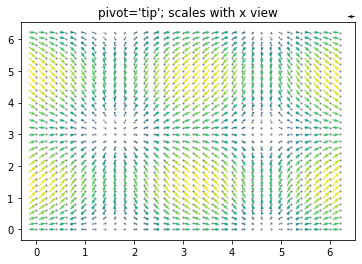

In [2]:
# --------------------------------
# quiver example 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl 
import time 
from numpy import ma

from scipy.interpolate import griddata 
from pylab import *
from kde_plus_gmm import kde_plus_gmm 

X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
U = np.cos(X)
V = np.sin(Y)

fig3, ax3 = plt.subplots()
ax3.set_title("pivot='tip'; scales with x view")
M = np.hypot(U, V)
Q = ax3.quiver(X, Y, U, V, M, units='x', pivot='tip', width=0.022,
               scale=1 / 0.15)
qk = ax3.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')
ax3.scatter(X, Y, color='0.5', s=1)

plt.show()